In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

/Users/mak/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


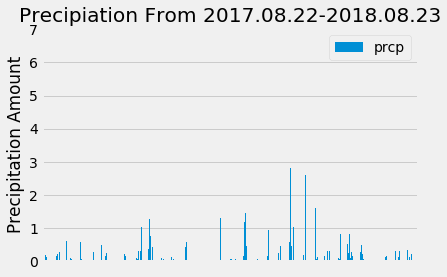

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
maxDate = engine.execute("select max(date) from measurement")

date = dt.date(2017,8,23)
yearago= date-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

prcpData = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>yearago)

# # Save the query results as a Pandas DataFrame and set the index to the date column
prcpDF = pd.DataFrame(prcpData, columns = ["date","prcp"])
prcpDF = prcpDF.set_index("date")

# # Sort the dataframe by date
prcpDF = prcpDF.sort_index()

# # Use Pandas Plotting with Matplotlib to plot the data

prcpDF.plot.bar()
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.xlabel("Date")
plt.ylabel("Precipitation Amount")
plt.title("Precipiation From 2017.08.24-2018.08.23")

#plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
stationCount = session.query(Measurement).group_by(Measurement.station).count()
stationCount

9

In [13]:
# # What are the most active stations? (i.e. what stations have the most rows)?
# # List the stations and the counts in descending order.

dataStations = session.query(Measurement.station, func.count(Measurement.date))\
                    .group_by(Measurement.station).order_by(func.count(Measurement.date)\
                    .desc()).all()
dataStations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowestTemp= session.query(func.min(Measurement.tobs)).filter_by(station="USC00519281").scalar()
highestTemp = session.query(func.max(Measurement.tobs)).filter_by(station = "USC00519281").scalar()
avgTemp = session.query(func.avg(Measurement.tobs)).filter_by(station="USC00519281").scalar()
print(f"Highest Temp: {highestTemp}.\nLowest Temp: {lowestTemp}.\nAverage Temp: {avgTemp}.")

Highest Temp: 85.0.
Lowest Temp: 54.0.
Average Temp: 71.66378066378067.


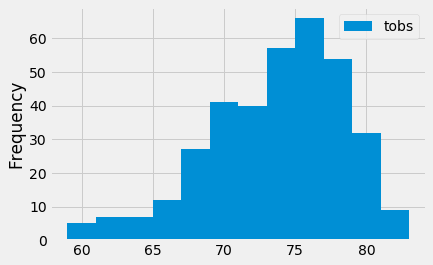

In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
maxDateStation = engine.execute("select max(date) from Measurement where station = 'USC00519281'")
stationDate = dt.date(2017,8,18)
stationYearago= date-dt.timedelta(days=365)

stationData = engine.execute("select tobs, date from Measurement where date>='2016-08-18' and station= 'USC00519281'")
stationDataDF = pd.DataFrame(stationData, columns=["tobs", "date"])
stationDataDF.plot.hist(bins=12)
plt.xlabel("Temp (F)")
plt.title("Frequency of Temps from 2016.08.18-2017.08.17")
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-02-29', '2016-03-13'))

[(62.0, 70.32584269662921, 79.0)]


/Users/mak/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


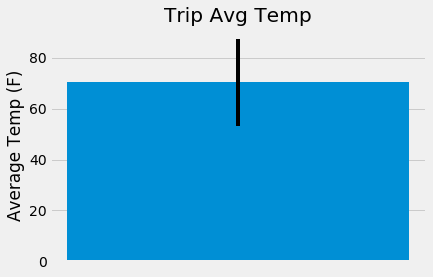

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temps = calc_temps('2016-02-29', '2016-03-13')
temps = pd.DataFrame(temps, columns =["min", "avg", "max"])

minTemp= temps.iloc[0][0]
avgTemp = temps.iloc[0][1]
maxTemp = temps.iloc[0][2]

yvalue = avgTemp
yerr=maxTemp-minTemp

plt.bar(1,yvalue,yerr=yerr)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.title("Trip Avg Temp")
plt.ylabel("Average Temp (F)")
plt.show()

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount and 
# list the station, name, latitude, longitude, and elevation
combined = session.query(Measurement, Station).filter(Measurement.station==Station.station).limit(10).all()

# session.query(Measurement.station, func.count(Measurement.date))\
#                     .group_by(Measurement.station).order_by(func.count(Measurement.date)\
#                     .desc()).all()

# tripPrcp = session.query(combined.prcp, func.sum(combined.prcp))

# query for prcp, group by station, turn to df. query for station info, turn to df. Merge the dfs?

,measurement,station
0,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
1,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
2,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
3,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
4,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
5,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
6,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
7,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
8,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...
9,<sqlalchemy.ext.automap.measurement object at ...,<sqlalchemy.ext.automap.station object at 0x12...


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
